In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.lines as mlines
import os
from IPython.display import display
import networkx as nx
import statistics
import scipy.stats as st
from sklearn.metrics import jaccard_score
from haversine import haversine
import math

In [2]:
df_martix = pd.read_csv('./study_data/cities_gzh_aja_martix.csv')
df_citys = pd.read_csv('./study_data/sa340.csv')
df_martix.set_index('city', inplace=True)
rank = pd.read_csv('./study_data/score/城市信息+排名得分综合表.csv')
df_in_out = pd.read_csv('./study_data/all_cities_in_out_count.csv')

# cities_in_out_flows

In [3]:
def get_in_out_by_cites_list(cn_name_list, title):   
    cn_name_list = list(cn_name_list)
    print('{} 城市有：{}'.format(title, cn_name_list))
    data = []
    for i in range(len(cn_name_list)):
        cn_name = cn_name_list[i]
        en_name = rank[rank.name==cn_name]['en_name'].values[0]
        data.append([cn_name, en_name, df_in_out[df_in_out.cityname == cn_name]['in-count'].values[0], 'in'])
        data.append([cn_name, en_name, df_in_out[df_in_out.cityname == cn_name]['out-count'].values[0], 'out'])
    df = pd.DataFrame(data, columns=['name', 'City Name', 'Count', 'type'])
    display(df)
    return df

def show_bar(df, name):
    #///////////可视化////////
    sns.set_style("whitegrid")
    COLOR = '#046AC4'
    plt.figure(figsize=(6, 3))
    ax = sns.barplot(x='City Name', y='Count', hue='type',width=0.8, data=df, palette=['#EE3824', '#74D192'])
    plt.xlabel('City Name', fontsize=11, fontweight=600)  
    plt.ylabel('Citation', fontsize=11, fontweight=600) 
    
    ax.tick_params(axis='x', labelsize=10)
    ax.tick_params(axis='y', labelsize=10)
    
    plt.xticks(rotation=45, ha='center')

    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.0f'), 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha = 'center', 
                    va = 'center', 
                    xytext = (0, 3), fontsize=10,
                    textcoords = 'offset points')
        
    plt.tight_layout() 
    
    plt.savefig('./地图_QGIS/top10_last10/' + name + '_in_out.pdf', format='pdf', dpi=600)
    plt.show()

# Top 10 城市分析

top10 城市有：['北京市', '上海市', '广州市', '深圳市', '杭州市', '香港特别行政区', '成都市', '重庆市', '天津市', '武汉市']


,name,City Name,Count,type
0,北京市,Beijing,36899,in
1,北京市,Beijing,836,out
2,上海市,Shanghai,22841,in
3,上海市,Shanghai,3197,out
4,广州市,Guangzhou,12751,in
5,广州市,Guangzhou,783,out
6,深圳市,Shenzhen,11783,in
7,深圳市,Shenzhen,3292,out
8,杭州市,Hangzhou,10219,in
9,杭州市,Hangzhou,1849,out


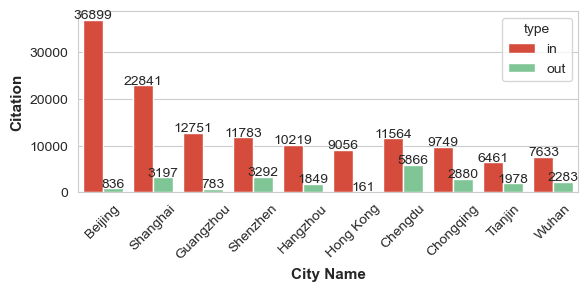

In [4]:
rank_top10 = rank.sort_values(by='ARI', ascending=False).reset_index(drop=True)[0:10]
df_top10 = get_in_out_by_cites_list(rank_top10['name'], 'top10')
show_bar(df_top10, 'top10')

# Last 10 城市分析

last10 城市有：['儋州市', '博尔塔拉蒙古自治州', '石嘴山市', '锡林郭勒盟', '克拉玛依市', '三沙市', '海东市', '林芝市', '怒江傈僳族自治州', '山南市']


,name,City Name,Count,type
0,儋州市,Danzhou,168,in
1,儋州市,Danzhou,3,out
2,博尔塔拉蒙古自治州,Bortala Mongolian Autonomous Prefecture,145,in
3,博尔塔拉蒙古自治州,Bortala Mongolian Autonomous Prefecture,374,out
4,石嘴山市,Shizuishan,122,in
5,石嘴山市,Shizuishan,298,out
6,锡林郭勒盟,Xilingol League,103,in
7,锡林郭勒盟,Xilingol League,652,out
8,克拉玛依市,Karamay,93,in
9,克拉玛依市,Karamay,10,out


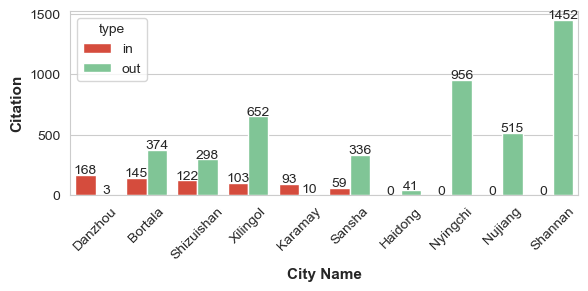

In [5]:
rank_last10 = rank.sort_values(by='ARI', ascending=False).reset_index(drop=True).tail(10)
df_last10 = get_in_out_by_cites_list(rank_last10['name'], 'last10')
df_last10['City Name'] = [i.split(' ')[0] for i in df_last10['City Name']]

show_bar(df_last10, 'last10')

# inter-city

In [8]:
def show_conn(cityA, cityB):
    _delta = 1/340 
    v_B2A = df_martix.loc[cityB, cityA]
    v_A2B = df_martix.loc[cityA, cityB]
    
    v = math.sqrt(v_B2A * v_A2B)
    
    
    return [cityA, cityB, v_A2B, v_B2A, v]
    
    
cities = ['北京市', '上海市', '广州市', '深圳市', 
          '杭州市', '香港特别行政区', '成都市', '重庆市']
datas = []
for i in cities:
    for j in cities:
        if i != j:
            datas.append(show_conn(i, j))
            
temp = pd.DataFrame(datas, columns=['cityA', 'cityB', 'A2B', 'B2A', 'intensity'])
temp = temp.sort_values(by='intensity', ascending=False)